# Train Custom Image Captioning Model

### Install Necessary Dependencies

In [1]:
%pip install transformers transformers[torch] huggingface_hub rouge_score evaluate datasets wandb sentencepiece

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=a76496bad4adab1c652fca1821b5640b6512c723c82db998f

In [2]:
import os
import gc
import torch
import evaluate
import numpy as np
from PIL import Image
from transformers import *
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
import wandb
from huggingface_hub import notebook_login

device = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `sr

In [3]:
HOME = os.getcwd()
print(HOME)

/content


In [4]:
notebook_login()

In [5]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Loading the Model

In [6]:
encoder_model = "microsoft/swin-base-patch4-window7-224-in22k"
decoder_model = "gpt2"

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_model, decoder_model
).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(decoder_model)
image_processor = ViTImageProcessor.from_pretrained(encoder_model)

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
    "rose_window, rosette": 9916,
    "roseate_spoonbill, Ajaia_ajaja": 1912,
    "rosebay, Rhododendron_maxima": 19033,
    "rosebud": 17526,
    "rosebud_cherry, winter_flowering_cherry, Prunus_subhirtella": 20120,
    "rosebud_orchid, Cleistes_rosea, Pogonia_rosea": 18520,
    "rosefish, ocean_perch, Sebastodes_marinus": 4079,
    "roselle, rozelle, sorrel, red_sorrel, Jamaica_sorrel, Hibiscus_sabdariffa": 18887,
    "rosemary": 13339,
    "rosemary, Rosmarinus_officinalis": 20711,
    "rosewood, rosewood_tree": 19778,
    "rosilla, Helenium_puberulum": 18324,
    "rosin_bag": 9917,
    "rosinweed, Silphium_laciniatum": 18422,
    "rosita, Centaurium_calycosum": 19186,
    "rosy_boa, Lichanura_trivirgata": 1199,
    "rotary_actuator, positioner": 9918,
    "rotary_engine": 9919,
    "rotary_press": 9920,
    "rotating_mechanism": 9921,
    "rotating_shaft, shaft": 9922,
    "rotavirus": 258,
    "rotgut": 13998,
    "rotifer": 1728,

model.safetensors:   0%|          | 0.00/437M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--microsoft--swin-base-patch4-window7-224-in22k/snapshots/68dc76680a5bf3bdf670669f3025dc9be2e30781/model.safetensors
Some weights of the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of SwinModel were initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k.
If your task is similar to the task the model of the

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_vers

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/model.safetensors
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

All model checkpoint weights were used when initializing GPT2LMHeadModel.

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.5.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.2.ln_cross_attn.bias', 'h.4.crossattention.c_attn.bias', 'h.7.crossattention.c_proj.weight', 'h.7.crossattention.c_attn.weight', 'h.4.crossattention.c_attn.weight', 'h.2.crossattention.q_attn.weight', 'h.0.crossattention.c_proj.weight', 'h.10.crossattention.c_proj.weight', 'h.0.ln_cross_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.11.crossattention.q_attn.bias', 'h.9.ln_cross_attn.weight', 'h.9.crossattention.q_attn.bias', 'h.2.ln_cross_att

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

Setting `config.is_decoder=True` and `config.add_cross_attention=True` for decoder_config
Generate config GenerationConfig {}



vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_ran

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-base-patch4-window7-224-in22k/snapshots/68dc76680a5bf3bdf670669f3025dc9be2e30781/preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



#### Config tokenizer

In [7]:
tokenizer.pad_token = tokenizer.eos_token
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id

### Download Dataset

In [8]:
!git clone https://huggingface.co/datasets/pasindu/google_conceptual_captions_20000

Cloning into 'google_conceptual_captions_20000'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 4
Unpacking objects: 100% (11/11), 1.55 KiB | 794.00 KiB/s, done.
Filtering content: 100% (3/3), 1.17 GiB | 48.54 MiB/s, done.


In [9]:
max_length = 32
train_split = load_dataset("/content/google_conceptual_captions_20000", split="train[:10%]")
validation_split = load_dataset("/content/google_conceptual_captions_20000", split="train[10%:15%]")
test_split = load_dataset("/content/google_conceptual_captions_20000", split="train[50%:55%]")
len(train_split), len(validation_split), len(test_split)

Generating train split:   0%|          | 0/14154 [00:00<?, ? examples/s]

(1415, 708, 708)

#### Remove Grayscale Images

In [10]:
train_split = train_split.filter(lambda item: np.array(item["image_data"]).ndim in [3, 4], num_proc=2)
validation_split = validation_split.filter(lambda item: np.array(item["image_data"]).ndim in [3, 4], num_proc=2)
test_split = test_split.filter(lambda item: np.array(item["image_data"]).ndim in [3, 4], num_proc=2)

Filter (num_proc=2):   0%|          | 0/1415 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/708 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/708 [00:00<?, ? examples/s]

#### Preprocess Images

In [11]:
def preprocess(items):
  pixel_values = image_processor(items["image_data"], return_tensors="pt").pixel_values.to(device)
  targets = tokenizer(items["caption"], max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").to(device)
  return {'pixel_values': pixel_values, 'labels': targets["input_ids"]}

In [12]:
train_dataset = train_split.with_transform(preprocess)
valid_dataset = train_split.with_transform(preprocess)
test_dataset  = test_split.with_transform(preprocess)

#### Collate the batches

In [13]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch])
    }

### Evaluation Metrics

In [14]:
# load the bleu and rouge metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

In [15]:
def compute_metrics(eval_pred):
  predictions = eval_pred.label_ids
  labels = eval_pred.predictions
  prediction_string = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  labels_string = tokenizer.batch_decode(labels, skip_special_tokens=True)
  rouge_result = rouge.compute(predictions=prediction_string, references=labels_string)
  rouge_result = {k: round(v * 100, 4) for k, v in rouge_result.items()}
  bleu_result = bleu.compute(predictions=prediction_string, references=labels_string)
  return {
    **rouge_result,
    "bleu": round(bleu_result["bleu"] * 100, 4),
    "gen_len": bleu_result["translation_length"] / len(predictions)
    }

### Training

In [16]:
num_epochs = 50
batch_size = 8

In [17]:
for item in train_dataset:
  print(item["labels"].shape)
  print(item["pixel_values"].shape)
  break

torch.Size([32])
torch.Size([3, 224, 224])


In [18]:
os.environ["WANDB_PROJECT"]="Custom Image Captioning Model"
os.environ["WANDB_LOG_MODEL"]="true"
os.environ["WANDB_WATCH"]="false"

In [19]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,             # use generate to calculate the loss
    num_train_epochs=num_epochs,            # number of epochs
    evaluation_strategy="steps",            # evaluate after each eval_steps
    report_to="wandb",                      # enable logging to W&B
    eval_steps=2000,                        # evaluate after each 2000 steps
    logging_steps=2000,                     # log after each 2000 steps
    save_steps=2000,                        # save after each 2000 steps
    per_device_train_batch_size=batch_size, # batch size for training
    per_device_eval_batch_size=batch_size,  # batch size for evaluation
    output_dir="vit-swin-base-224-gpt2-image-captioning", # output directory
    # push_to_hub=True,                       # push the model to the hub when finished
)

PyTorch: setting up devices


In [20]:
trainer = Seq2SeqTrainer(
    model=model,                     # the instantiated 🤗 Transformers model to be trained
    tokenizer=image_processor,       # we use the image processor as the tokenizer
    args=training_args,              # pass the training arguments
    compute_metrics=compute_metrics, # pass the compute metrics function
    train_dataset=train_dataset,     # pass the training dataset
    eval_dataset=valid_dataset,      # pass the validation dataset
    data_collator=collate_fn,        # pass the collate function
)

Setting `WANDB_LOG_MODEL` from true to `end` instead


In [21]:
def get_eval_loader(eval_dataset=None):
  return DataLoader(valid_dataset, collate_fn=collate_fn, batch_size=batch_size)

def get_test_loader(eval_dataset=None):
  return DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size)

trainer.get_train_dataloader = lambda: DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size)
trainer.get_eval_dataloader = get_eval_loader
trainer.get_test_dataloader = get_test_loader

In [22]:
trainer.train()

***** Running training *****
  Num examples = 1,401
  Num Epochs = 50
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8,800
  Number of trainable parameters = 240,337,080
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


wandb: Currently logged in as: pakalpa. Use `wandb login --relogin` to force relogin


***** Running Evaluation *****
  Num examples = 1401
  Batch size = 8
Generate config GenerationConfig {
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256
}

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Saving model checkpoint to vit-swin-base-224-gpt2-image-captioning/checkpoint

TrainOutput(global_step=8800, training_loss=0.16047357571395962, metrics={'train_runtime': 5459.233, 'train_samples_per_second': 12.831, 'train_steps_per_second': 1.612, 'total_flos': 1.2713694261837005e+19, 'train_loss': 0.16047357571395962, 'epoch': 50.0})

In [23]:
wandb.finish()

In [24]:
wandb.init()
trainer.evaluate(test_dataset)
wandb.finish()

***** Running Evaluation *****
  Num examples = 1401
  Batch size = 8
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [27]:
trainer.save_model("./captioning_model")

Saving model checkpoint to ./captioning_model
Configuration saved in ./captioning_model/config.json
Configuration saved in ./captioning_model/generation_config.json
Model weights saved in ./captioning_model/pytorch_model.bin
Image processor saved in ./captioning_model/preprocessor_config.json


In [25]:
trainer.push_to_hub()

Saving model checkpoint to vit-swin-base-224-gpt2-image-captioning
Configuration saved in vit-swin-base-224-gpt2-image-captioning/config.json
Configuration saved in vit-swin-base-224-gpt2-image-captioning/generation_config.json
Model weights saved in vit-swin-base-224-gpt2-image-captioning/pytorch_model.bin
Image processor saved in vit-swin-base-224-gpt2-image-captioning/preprocessor_config.json


model.safetensors:   0%|          | 0.00/962M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/pasindu/vit-swin-base-224-gpt2-image-captioning/commit/7651e76f2fc7cb6907c3208f1e8ec7ebd0942ace', commit_message='End of training', commit_description='', oid='7651e76f2fc7cb6907c3208f1e8ec7ebd0942ace', pr_url=None, pr_revision=None, pr_num=None)

In [26]:
# Free GPU memory
torch.cuda.empty_cache()
gc.collect()

12170

### Model Evaluation

In [30]:
def get_evaluation_metrics(model, dataset):
  model.eval()
  dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size)
  n_test_steps = len(dataloader)
  predictions, labels = [], []
  test_loss = 0.0
  for batch in tqdm(dataloader, "Evaluating"):
      pixel_values = batch["pixel_values"]
      label_ids = batch["labels"]
      outputs = model(pixel_values=pixel_values, labels=label_ids)
      loss = outputs.loss
      test_loss += loss.item()
      logits = outputs.logits.detach().cpu()
      predictions.extend(logits.argmax(dim=-1).tolist())
      labels.extend(label_ids.tolist())
  eval_prediction = EvalPrediction(predictions=predictions, label_ids=labels)
  metrics = compute_metrics(eval_prediction)
  metrics["test_loss"] = test_loss / n_test_steps
  return metrics

In [28]:
best_model = VisionEncoderDecoderModel.from_pretrained("./captioning_model").to(device)

Streaming output truncated to the last 5000 lines.
      "roundhead": 16691,
      "roundhouse": 9943,
      "router": 9945,
      "router_plane": 9946,
      "roux": 13463,
      "rove_beetle": 2587,
      "row_house, town_house": 9948,
      "rowan, rowan_tree, European_mountain_ash, Sorbus_aucuparia": 20148,
      "rowanberry": 20149,
      "rowel": 9947,
      "rowing, row": 48,
      "rowing_boat": 9949,
      "rowlock_arch": 9950,
      "royal": 9951,
      "royal, royal_stag": 3464,
      "royal_agaric, Caesar's_agaric, Amanita_caesarea": 21053,
      "royal_fern, royal_osmund, king_fern, ditch_fern, French_bracken, Osmunda_regalis": 20956,
      "royal_mast": 9952,
      "royal_palm, Roystonea_regia": 19971,
      "royal_poinciana, flamboyant, flame_tree, peacock_flower, Delonix_regia, Poinciana_regia": 19717,
      "royal_tennis, real_tennis, court_tennis": 171,
      "rubber_band, elastic_band, elastic": 9953,
      "rubber_boa, tow-headed_snake, Charina_bottae": 1198,
      

In [39]:
metrics = get_evaluation_metrics(best_model, test_dataset)
metrics

Evaluating: 100%|██████████| 88/88 [00:54<00:00,  1.61it/s]


{'rouge1': 23.9887,
 'rouge2': 5.2642,
 'rougeL': 22.7729,
 'rougeLsum': 22.7725,
 'bleu': 2.8665,
 'gen_len': 10.430615164520743,
 'test_loss': 3.1577734527262775}

### Perform Inference

In [32]:
import urllib.parse as parse
import os
import requests

def is_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False

def load_image(image_path):
    if is_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)

def get_caption(model, image_processor, tokenizer, image_path):
    image = load_image(image_path)
    img = image_processor(image, return_tensors="pt").to(device)
    output = model.generate(**img)
    caption = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    return caption

In [33]:
def show_image_and_captions(url):
  display(load_image(url))
  our_caption = get_caption(best_model, image_processor, tokenizer, url)
  print(f"Our caption: {our_caption}")

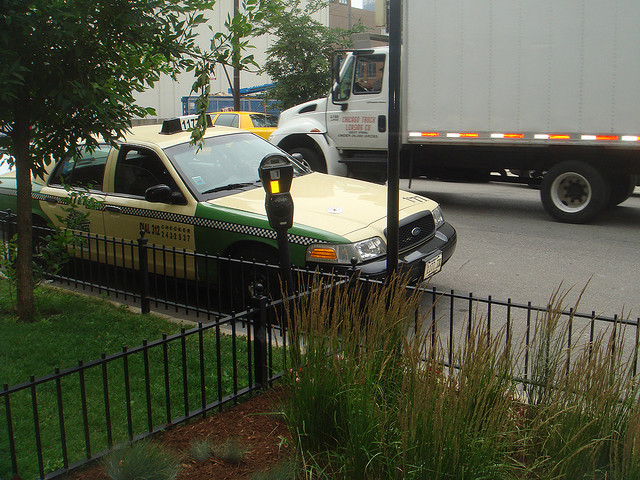

Our caption: a car parked outside a hotel displays signs.


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [34]:
show_image_and_captions("http://images.cocodataset.org/test-stuff2017/000000000001.jpg")

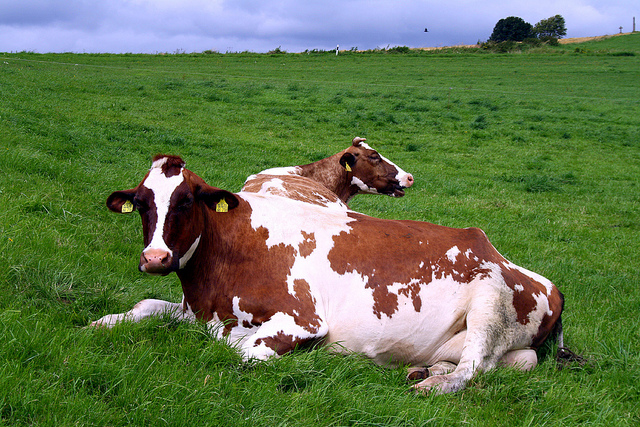

Our caption: a young black and white spotted cow walks through a green spring field in the sunshine


In [35]:
show_image_and_captions("http://images.cocodataset.org/test-stuff2017/000000000019.jpg")

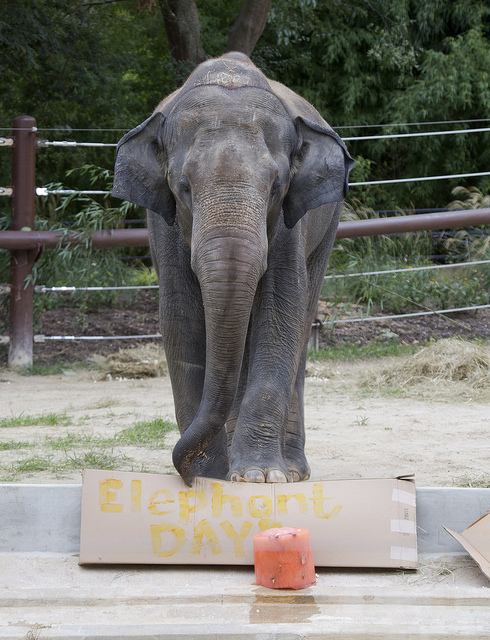

Our caption: biological species, or biological species, with a calf walks near tourists.


In [36]:
show_image_and_captions("http://images.cocodataset.org/test-stuff2017/000000000128.jpg")

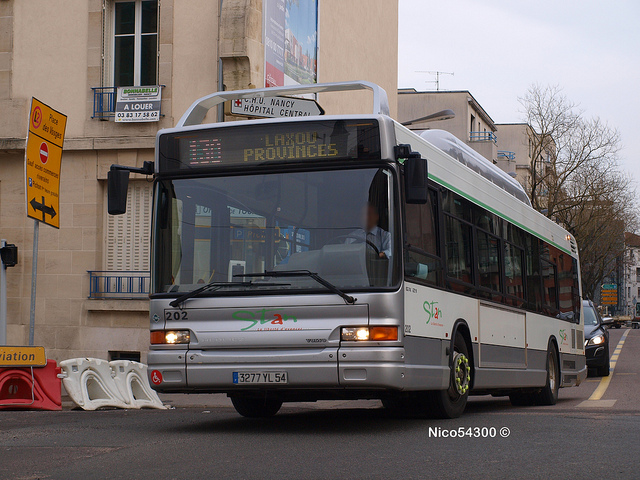

Our caption: a swarm of bees appeared on a set of traffic lights at the junction


In [37]:
show_image_and_captions("http://images.cocodataset.org/test-stuff2017/000000003324.jpg")

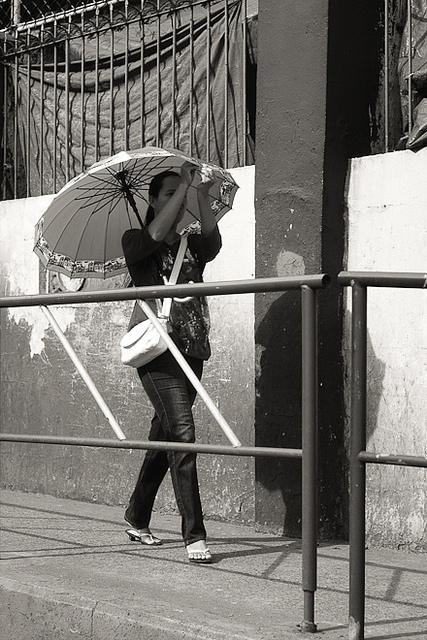

Our caption: celebrity in a suit, standing at the edge of a parking garage


In [38]:
show_image_and_captions("http://images.cocodataset.org/test-stuff2017/000000003720.jpg")